In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

### Input data

In [19]:
#experimental data
fluo = pd.read_csv('datasets/bulk-fluo-11.csv', index_col=0)
od = pd.read_csv('datasets/od-11.csv', index_col=0)

In [20]:
#take only the best 3 models and put together in a single dataframe
output_path = 'inference-scaled/best_so_far/'
best3_models = pd.DataFrame()

for i, col in enumerate(fluo.columns.tolist()):
    name = str(i) + '-' + col
    model = pd.read_csv('datasets/' + output_path + name + '.csv')
    best3_models = pd.concat([best3_models, model.iloc[:,0:3]], axis=1)

In [21]:
map_idx = {
    0: 'SynECFn', 1: 'DegECFn', 2: 'SynECFc', 3: 'DegECFc', 
    4: 'SplitECF', 5: 'DegECF', 6: 'SynGFP', 7: 'DegGFP',
    8: 'K', 9: 'n'
}
map_idx_scaled = {
    0: 'DegECFc', 1: 'DegECFn',
    2: 'SplitECF', 3: 'DegECF', 4: 'SynGFP', 5: 'DegGFP',
    6: 'n'
}
best3_models2 = best3_models.reset_index()
best3_models2['index'] = best3_models2['index'].map(map_idx_scaled)
best3_models2

,index,6e15SspGyrB,2e15SspGyrB,1e15SspGyrB,3e22SspGyrB,8e22SspGyrB,2e22SspGyrB,3e32SspGyrB,8e32SspGyrB,4e32SspGyrB,5e33SspGyrB,7e33SspGyrB,4e33SspGyrB,3e34SspGyrB,7e34SspGyrB,2e34SspGyrB,2e41SspGyrB,5e41SspGyrB,1e41SspGyrB,1e42SspGyrB,7e42SspGyrB,5e42SspGyrB,0e15TerThyXS2,5e15TerThyXS2,8e15TerThyXS2,8e22TerThyXS2,2e22TerThyXS2,1e22TerThyXS2,6e38TerThyXS2,5e38TerThyXS2,1e38TerThyXS2,1e16TerThyXS1,8e16TerThyXS1,5e16TerThyXS1,5e33TerThyXS1,4e33TerThyXS1,0e33TerThyXS1,7e15STPhoRadA,2e15STPhoRadA,1e15STPhoRadA,1e16STPhoRadA,6e16STPhoRadA,5e16STPhoRadA,1e17STPhoRadA,5e17STPhoRadA,6e17STPhoRadA,5e20STPhoRadA,8e20STPhoRadA,2e20STPhoRadA,8e22STPhoRadA,6e22STPhoRadA,3e22STPhoRadA,5e26STPhoRadA,1e26STPhoRadA,3e26STPhoRadA,3e32STPhoRadA,0e32STPhoRadA,1e32STPhoRadA,3e33STPhoRadA,8e33STPhoRadA,1e33STPhoRadA,0e34STPhoRadA,5e34STPhoRadA,3e34STPhoRadA
0,DegECFc,2.238016,2.384055,19.477854,17.098273,0.196746,18.961426,0.188956,1.001914,1.742203,2.140399,0.796942,0.032749,0.710449,0.319765,0.128042,6.374752,0.381529,3.253216,1.909873,3.193425,129.386984,0.176849,2.195732,1.866475,1.082026,2.408240,0.708050,1.663020,1.069844,1.748813,1.893803,2.183023,0.946758,1.580120,4.001880,5.611881,3.073677,3.318197,2.609252,0.101836,4.530439,2.846370,3.174564,6.177341,19.600412,0.840246,4.963881,179.270696,0.764297,1.842303,5.992456,2.743826,1.202066,3.506008,1.570526,35.446256,0.552574,30.737196,8.788295,0.197637,1.639832,1.042960,7.426004
1,DegECFn,0.331144,2.251164,0.875508,0.042383,80.212928,0.229983,1.268262,4.608728,1.182631,2.011901,3.091982,143.308346,0.762761,1.407903,0.623830,5.625244,4.073702,4.135618,1.643277,5.273443,0.711493,0.278351,2.547785,1.567566,0.991768,2.518747,0.650777,1.502397,1.212521,0.738597,10.596689,0.006067,0.937691,1.896345,4.033160,6.038454,2.802019,3.137496,1.386580,6.010069,4.069970,2.779619,21.826727,6.170914,11.338514,0.675607,2.930123,0.455720,0.416998,1.400148,0.582641,7.477476,1.784977,4.008245,1.803188,0.996478,0.610890,1.632086,4.747270,3.532360,2.176331,6.010043,0.506268
2,SplitECF,5.492043,9.968144,355.127973,5.243773,146.681643,21.585190,0.659862,38.023041,2.880753,6.639948,14.068357,56.476676,0.633399,0.496017,0.587684,27.159145,59.800182,65.971754,77.290953,98.789186,88.155193,0.154037,9.315619,8.269112,2.381366,0.469030,5.794121,0.806398,9.741510,5.751299,67.066166,3.511779,0.416735,5.889095,0.989406,251.024173,21.402527,21.132756,11.720338,8.253678,72.815476,63.389429,98.259454,358.539206,28.287859,0.121255,24.151182,55.451222,0.250966,3.199762,5.554303,49.003142,3.775018,5.826326,5.030764,47.186792,5.058418,145.105061,128.591323,26.599016,126.824546,24.507724,3.800267
3,DegECF,3.935325,1.537507,16.959592,1.554916,5.860007,3.264658,1.082810,6.665214,1.049719,1.319072,4.400622,1.381274,0.662142,0.539067,1.634582,0.701304,22.448461,4.363860,23.503878,5.758632,0.912316,0.490454,1.332968,2.077665,1.438063,0.042189,7.172123,0.070248,3.375102,1.906425,2.857590,4.357132,0.210281,1.211496,0.005418,6.331549,1.998900,1.676060,2.240297,4.908469,3.678897,7.178570,1.383586,9.249722,0.094976,0.027121,1.503465,0.417582,0.552009,1.149847,1.371964,2.203587,1.388219,0.364141,1.454410,1.112137,8.633749,2.819353,3.031323,25.030266,29.395329,3.173019,0.646652
4,SynGFP,3028.786707,2800.573303,3658.871411,1071.719522,1092.670761,1039.017430,4270.349221,4268.528145,3624.590749,204.037543,187.802117,181.625044,7231.383913,9711.309086,5213.746729,3190.314918,2895.588335,2905.507952,1705.849708,1811.083707,2880.480217,126.488309,132.887250,125.644386,85.822217,791.818703,97.819806,246.205559,250.600656,254.600894,2286.575406,2513.984836,1955.595735,83.626833,1482.114123,67.136349,166.382967,176.733622,149.939257,4060.249882,3272.187165,3109.249669,1062.185393,1119.044205,964.641339,3799.400795,3808.184080,3655.235458,910.507811,947.476733,854.790361,412.179248,415.683606,411.328418,680.779808,663.993419,659.469560,2083.674516,1655.739638,1428.465131,2136.513921,2077.137748,1880.208513
5,DegGFP,0.110169,0.100895,0.136579,0.095536,0.09734

In [22]:
#pivoting the values into a single column (and param and dataset name as the key columns)
best3_models3 = best3_models2.melt(id_vars=['index'])
best3_models3

,index,variable,value
0,DegECFc,6e15SspGyrB,2.238016
1,DegECFn,6e15SspGyrB,0.331144
2,SplitECF,6e15SspGyrB,5.492043
3,DegECF,6e15SspGyrB,3.935325
4,SynGFP,6e15SspGyrB,3028.786707
...,...,...,...
436,SplitECF,3e34STPhoRadA,3.800267
437,DegECF,3e34STPhoRadA,0.646652
438,SynGFP,3e34STPhoRadA,1880.208513
439,DegGFP,3e34STPhoRadA,0.125516


In [23]:
best3_models3['index'].unique()

array(['DegECFc', 'DegECFn', 'SplitECF', 'DegECF', 'SynGFP', 'DegGFP',
       'n'], dtype=object)

In [24]:
best3_models3['variable'].unique()

array(['6e15SspGyrB', '2e15SspGyrB', '1e15SspGyrB', '3e22SspGyrB',
       '8e22SspGyrB', '2e22SspGyrB', '3e32SspGyrB', '8e32SspGyrB',
       '4e32SspGyrB', '5e33SspGyrB', '7e33SspGyrB', '4e33SspGyrB',
       '3e34SspGyrB', '7e34SspGyrB', '2e34SspGyrB', '2e41SspGyrB',
       '5e41SspGyrB', '1e41SspGyrB', '1e42SspGyrB', '7e42SspGyrB',
       '5e42SspGyrB', '0e15TerThyXS2', '5e15TerThyXS2', '8e15TerThyXS2',
       '8e22TerThyXS2', '2e22TerThyXS2', '1e22TerThyXS2', '6e38TerThyXS2',
       '5e38TerThyXS2', '1e38TerThyXS2', '1e16TerThyXS1', '8e16TerThyXS1',
       '5e16TerThyXS1', '5e33TerThyXS1', '4e33TerThyXS1', '0e33TerThyXS1',
       '7e15STPhoRadA', '2e15STPhoRadA', '1e15STPhoRadA', '1e16STPhoRadA',
       '6e16STPhoRadA', '5e16STPhoRadA', '1e17STPhoRadA', '5e17STPhoRadA',
       '6e17STPhoRadA', '5e20STPhoRadA', '8e20STPhoRadA', '2e20STPhoRadA',
       '8e22STPhoRadA', '6e22STPhoRadA', '3e22STPhoRadA', '5e26STPhoRadA',
       '1e26STPhoRadA', '3e26STPhoRadA', '3e32STPhoRadA', '0e32STPh

DegECFc


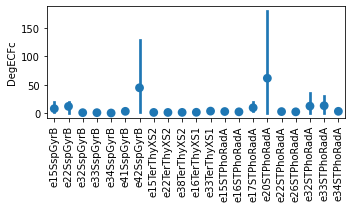

DegECFn


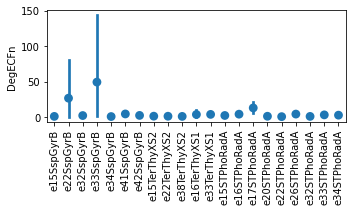

SplitECF


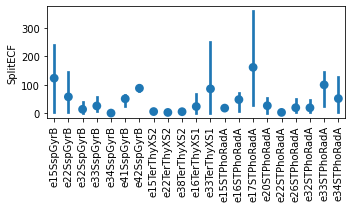

DegECF


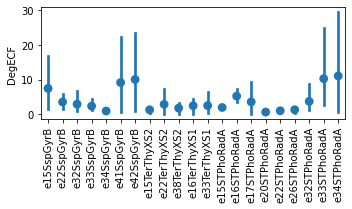

SynGFP


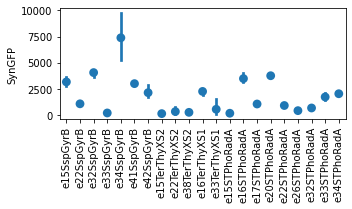

DegGFP


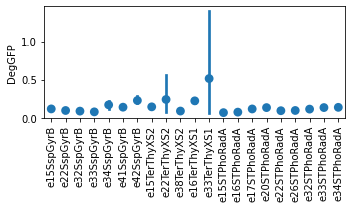

n


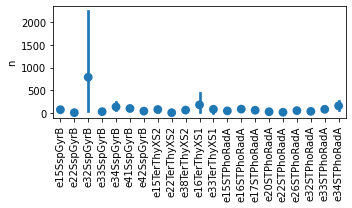

In [25]:
uniq_params = best3_models3['index'].unique().tolist()
for u in uniq_params:
    
    print(u)

    param = best3_models3[best3_models3['index']==u]
    param['variable'] = param['variable'].str[1:] #remove first character, as it is just indexes for different simulations
    #param['variable'] = param['variable'].str.split('.')[0]
    param['log_value'] = np.log(param['value'])

    fig = plt.figure(figsize=[5, 3])
    #fig.suptitle(u)

    #plt.subplot(1, 1, 1)
    #sns.boxplot(data=param, y='value', x='variable', showfliers=False)
    sns.pointplot(x="variable", y="value", data=param, join=False)
    plt.xticks(rotation=90)
    plt.ylabel(u)
    plt.xlabel(None)

    #plt.subplot(1, 2, 2)
    #sns.boxplot(data=param, y='log_value', x='variable', showfliers=False)
    #plt.xticks(rotation=90)
    #plt.ylabel('Log scaled')
    #plt.xlabel(None)
    
    plt.tight_layout()
    fig.savefig('datasets/' + output_path + '/plot2' + u + '.png')
    plt.show()

### Plot Best Fit

In [11]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def hill_equation(x, n):
    return x**n / (1 + x**n)

### Functions for 1st level inference (fitting growth data) ###
def od_wrapper(t, k1, k2):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_y0 = np.abs(od_data[0])
    od_rates = (k1, k2)
    od_sol = odeint(od_model, od_y0, t, od_rates)
    return od_sol[:,0]
### END ###

### Functions for 2nd level inference (fitting fluoresence data) ###
def gate_wrapper(t, a, b, c, d, e, f, g, extra, y0):

    def gate_model(y, t):
    
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        #parameters to infer
        deg_ECFn, deg_ECFc, syn_ECF, deg_ECF, syn_GFP, deg_GFP, n = a, b, c, d, e, f, g
        #fixed parameters
        mgr, mcc = extra
        #differential equations
        dOD = growth_rate(t, OD, mgr, mcc) * OD
        dECFn = 1 - (deg_ECFn + growth_rate(t, OD, mgr, mcc)) * ECFn
        dECFc = 1 - (deg_ECFc + growth_rate(t, OD, mgr, mcc)) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
        dGFP = syn_GFP * hill_equation(ECF, n) - (deg_GFP + growth_rate(t, OD, mgr, mcc)) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#wrapper function to accomodate Scipy's curve_fit
def model_fit(t, a, b, c, d, e, f, g):
    fit = gate_wrapper(t, a, b, c, d, e, f, g, extra, y0)
    return fit[3] #3 for GFP index

### END ###

In [12]:
od_bounds = [(0, 0), (1, 1)]
num_params = 7 #number of parameters to infer
gate_bounds = [[0]*num_params, [1e5]*num_params]

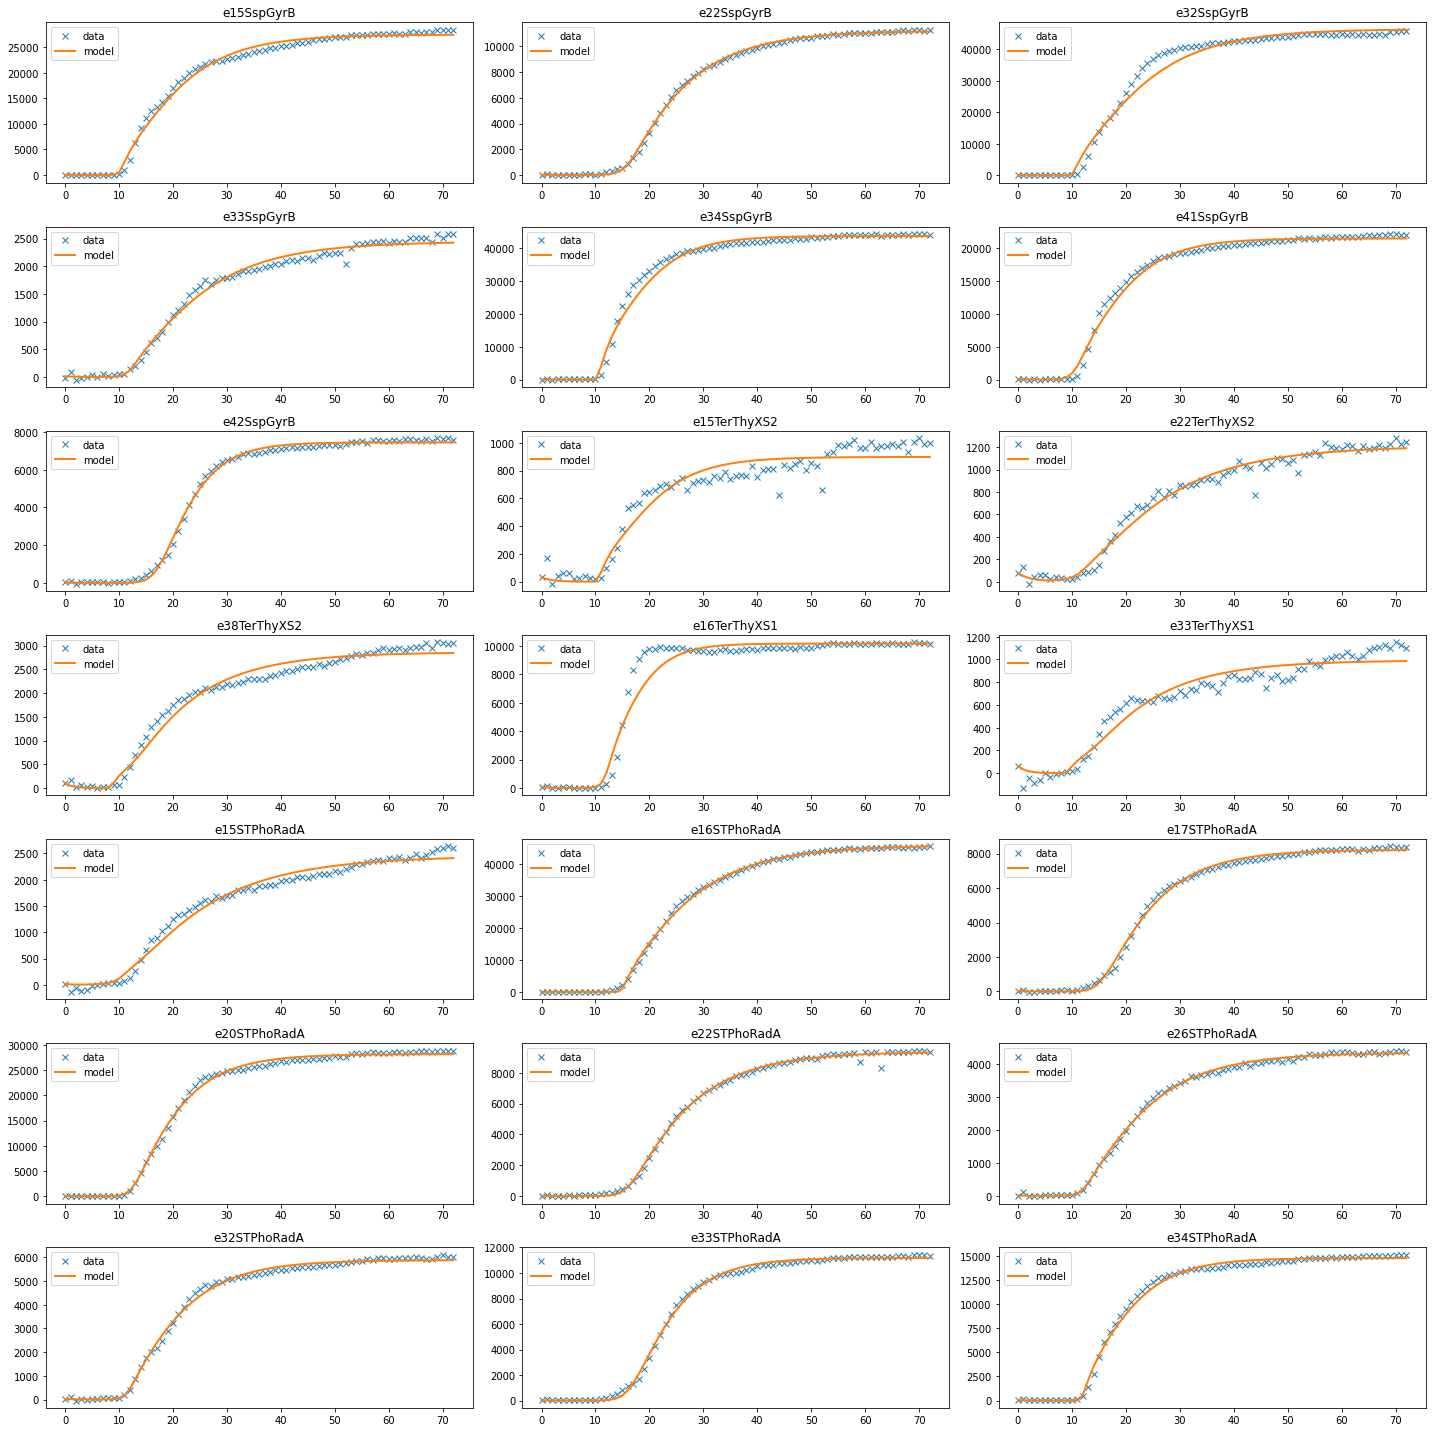

In [14]:
fig = plt.figure(figsize=(20, 20))
num_col = 3
num_vars = len(fluo.columns.tolist())
num_row = int(np.ceil(num_vars)/num_col)
for i in range(num_vars):
    plt.subplot(num_row, num_col, i+1)
    
    od_data = od[od.columns[i]]
    od_t = np.arange(0, len(od_data))
    od_params, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)

    fluo_data = fluo[fluo.columns[i]]
    t = np.arange(0, len(fluo_data))

    y0 = np.abs([0.0, 0.0, 0.0, fluo_data[0], od_data[0]])
    extra = od_params
    
    fluo_params = pd.read_csv('datasets/' + output_path + str(i) + '-' + fluo.columns[i] + '.csv').iloc[:,0]
    
    fit = gate_wrapper(t, *fluo_params, extra, y0)
    plt.plot(t, fluo_data, 'x', label='data')
    plt.plot(t, fit[3], '-', label='model', linewidth=2)

    plt.legend()
    plt.title(fluo.columns[i])
    #plt.xticks(rotation=90)
    plt.xlabel(None)
    
plt.tight_layout()
fig.savefig('datasets/' + output_path + '/best_fit.png')
plt.show()

#### $$ \frac{dS}{dt} = -\alpha \frac{S}{N} I \\
 \frac{dI}{dt} = \alpha \frac{S}{N} I - \beta I \\
 \frac{dR}{dt} = \beta I $$